### Scoring without CDRs
It is possible to score with AntPack while masking out or disregarding user-specified regions of
the sequence. This notebook generates scores using a variety of different masks and examines the
results. Note that scoring using all of the available masks will take a little time, and then
bootstrapping CIs on the AUC-ROC scores is also moderately time-consuming, so you should expect
this notebook to take a few minutes to run.

In [13]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.metrics import roc_auc_score
from antpack import SequenceScoringTool, SingleChainAnnotator

if "notebooks" in os.getcwd():
    os.chdir(os.path.join("..", ".."))
    current_dir = os.getcwd()

score_tool = SequenceScoringTool(adjusted_scores=False)
sc_annotator = SingleChainAnnotator()

os.chdir(current_dir)

We use IMGT definitions of CDRs to create masks for CDR 3 only,
CDR3 + CDR2, or all three CDRs for each chain. These masks are then used for masked scoring
(calculating the score with and without the masked regions).

In [14]:
imgt = {  "heavy":{"3":['105', '106', '107', '108', '109', '110', '111', '111A', '111B', '111C', '111D', '111E', '111F', '111G',
                        '111H', '111I', '111J', '111K', '112L', '112K', '112J', '112I', '112H', '112G', '112F', '112E',
                        '112D', '112C', '112B', '112A', '112', '113', '114', '115', '116', '117'],
                    "2":['56', '57', '58', '59', '60', '60A', '60B', '60C', '60D', '60E', '61E', '61D', '61C', '61B', '61A', '61',
                         '62', '63', '64', '65'],
                    "1":['27', '28', '29', '30', '31', '32', '32A', '32B', '32C', '33C', '33B', '33A',
                         '33', '34', '35', '36', '37', '38']
                    },
         "light":{  "3":['105', '106', '107', '108', '109', '110', '111', '111A', '111B', '111C', '111D', '112D', '112C', '112B', '112A',
                         '112', '113', '114', '115', '116', '117'],
                    "2":['56', '57', '58', '59', '60', '61', '62', '63', '64', '65'],
                    "1":['27', '28', '29', '30', '31', '32', '32A', '32B', '33B', '33A', '33', '34', '35', '36',
                        '37', '38']
                 }
        }

The next function scores a batch of sequences using various masks.

In [15]:
def score_sequence_group(seqs, chain, imgt_mask_grps, scoring_tool, annotation_tool):
    chain_map = {"heavy":"H", "light":"L"}
    numberings = [t[0] for t in annotation_tool.analyze_online_seqs(seqs) ]
    chain_types = [chain_map[chain] for a in numberings]

    scores, mask_categories = [], []
    
    for grp in [["3"], ["3", "2"], ["3", "2", "1"]]:
        print(f"{chain}, {grp}")
        grp_key = f"cdr_{'_'.join(grp)}_masked"

        imgt_mask_set = []
        for key in grp:
            imgt_mask_set += imgt[chain][key]

        masks = [imgt_mask_set for numbering in numberings]

        scores += scoring_tool.score_masked_sequences(seqs, chain_types, numberings, masks).tolist()
        mask_categories += [grp_key for a in numberings]

    scores += scoring_tool.batch_score_seqs(seqs).tolist()
    mask_categories += ["no_mask" for a in numberings]
    return scores, mask_categories

We now run the above function on each batch of 50,000 sequences in the test set. There are 450,000 sequences in
all and we are scoring them using 4 different settings, so this will take a few minutes.

In [16]:
if "results_and_resources" not in os.getcwd():
    os.chdir(os.path.join(current_dir, "results_and_resources"))


scoring = { chain:{"scores":[], "species":[], "labels":[], "mask_codes":[]} for chain in ["heavy", "light"]  }


for chain in ["heavy", "light"]:
    os.chdir(os.path.join(current_dir, "train_test_data_immunogenicity_0.0.2", f"{chain}_chain", "test_sample_sequences"))
    flist = [f for f in os.listdir() if f.endswith("fasta")]
    flist = sorted(flist)

    for fname in flist:
        print(fname)
        with open(fname, "r") as fhandle:
            slist = [str(s.seq) for s in SeqIO.parse(fhandle, "fasta")]

        scores, mask_cats = score_sequence_group(slist, chain, imgt, score_tool, sc_annotator)
        
        species = fname.split(".fasta")[0].split("test_subsample_")[1]
        if species.startswith("mouse"):
            scoring[chain]["species"] += ["mouse" for s in scores]
        else:
            scoring[chain]["species"] += [species for s in scores]
        scoring[chain]["scores"] += scores
        scoring[chain]["mask_codes"] += mask_cats

        if species == "human":
            scoring[chain]["labels"] += np.ones((len(scores))).tolist()
        else:
            scoring[chain]["labels"] += np.zeros((len(scores))).tolist()

test_subsample_camel.fasta
heavy, ['3']
heavy, ['3', '2']
heavy, ['3', '2', '1']
test_subsample_human.fasta
heavy, ['3']
heavy, ['3', '2']
heavy, ['3', '2', '1']
test_subsample_mouse_balbc.fasta
heavy, ['3']
heavy, ['3', '2']
heavy, ['3', '2', '1']
test_subsample_mouse_c576.fasta
heavy, ['3']
heavy, ['3', '2']
heavy, ['3', '2', '1']
test_subsample_rabbit.fasta
heavy, ['3']
heavy, ['3', '2']
heavy, ['3', '2', '1']
test_subsample_rat.fasta
heavy, ['3']
heavy, ['3', '2']
heavy, ['3', '2', '1']
test_subsample_rhesus.fasta
heavy, ['3']
heavy, ['3', '2']
heavy, ['3', '2', '1']
test_subsample_human.fasta
light, ['3']
light, ['3', '2']
light, ['3', '2', '1']
test_subsample_mouse_balbc.fasta
light, ['3']
light, ['3', '2']
light, ['3', '2', '1']
test_subsample_rhesus.fasta
light, ['3']
light, ['3', '2']
light, ['3', '2', '1']


In [19]:
dfs = {h:pd.DataFrame.from_dict(d) for (h,d) in scoring.items()}

In [20]:
dfs["heavy"].columns

Index(['scores', 'species', 'labels', 'mask_codes'], dtype='object')

In [10]:
combined_results = {"mask":[], "chain":[], "AUC-ROC":[], "AUC-ROC_LCB":[], "AUC-ROC_UCB":[]}

for chain in ["heavy", "light"]:
    print(f"AUC-ROC results, chain {chain}")
    df = dfs[chain]

    for mask in df.mask_codes.unique():
        subset = df[df["mask_codes"] == mask]
        auc_values = []
        gt_scores = subset["labels"].values
        input_scores = subset["scores"].values
        rng = np.random.default_rng(123)

        for i in range(1000):
            idx = rng.choice(gt_scores.shape[0], gt_scores.shape[0])
            auc_values.append(roc_auc_score(gt_scores[idx], input_scores[idx]))

        auc_values = np.sort(np.array(auc_values))
        score = roc_auc_score(gt_scores, input_scores)
        combined_results["mask"].append(mask)
        combined_results["chain"].append(chain)
        combined_results["AUC-ROC"].append(roc_auc_score(gt_scores, input_scores))
        combined_results["AUC-ROC_LCB"].append(auc_values[25])
        combined_results["AUC-ROC_UCB"].append(auc_values[975])

        print(f"{mask}:\t{score}\tLCB: {auc_values[25]}\tUCB:{auc_values[975]}")

    print("\n")

AUC-ROC results, chain heavy
cdr_3_masked:	0.9637237598319665	LCB: 0.962929837769972	UCB:0.9645540377461338
cdr_3_2_masked:	0.9536923566313263	LCB: 0.9527845831508843	UCB:0.9546624130942938
cdr_3_2_1_masked:	0.9491155336267254	LCB: 0.9481754656540441	UCB:0.9500275223158042
no_mask:	0.9537544028005602	LCB: 0.9528452277390939	UCB:0.9547312741157983


AUC-ROC results, chain light
cdr_3_masked:	0.9456147885630971	LCB: 0.9444388347656898	UCB:0.9467090522631314
cdr_3_2_masked:	0.9455552397921979	LCB: 0.9443890344854687	UCB:0.9466377979384246
cdr_3_2_1_masked:	0.9465629203187484	LCB: 0.9453479741390398	UCB:0.9476654536294578
no_mask:	0.9482599997943796	LCB: 0.9471203449587161	UCB:0.9493557608590446




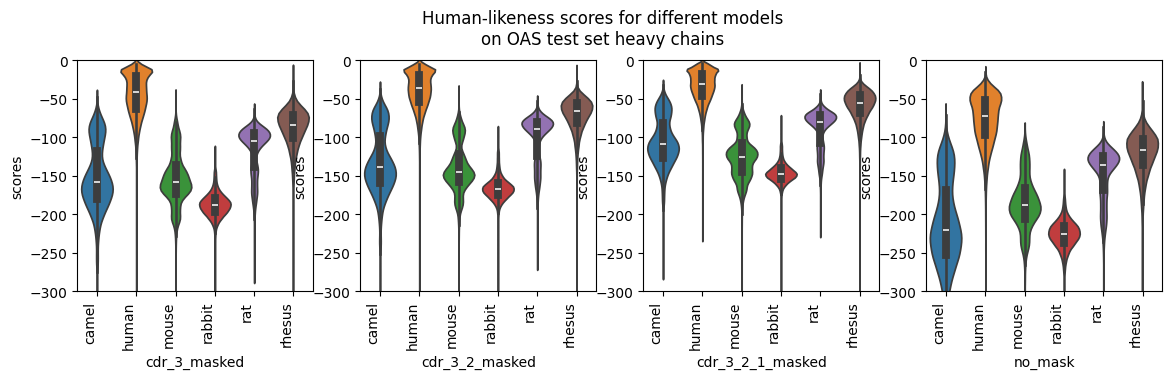

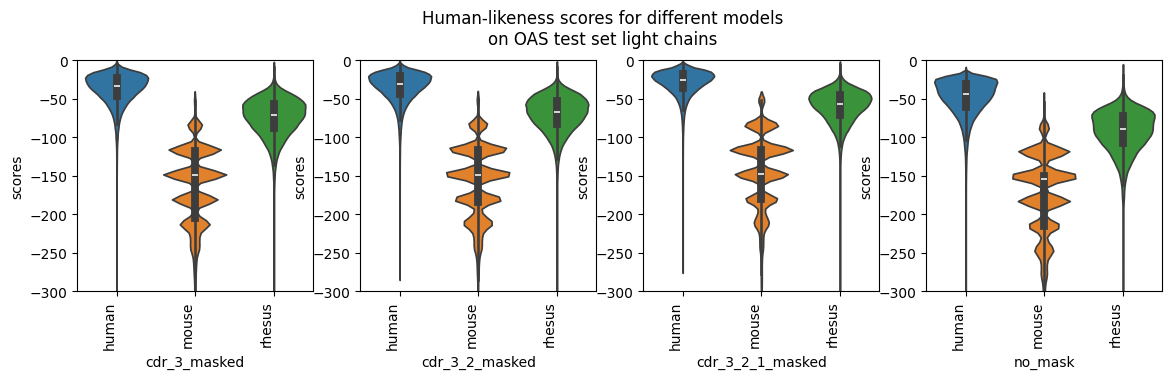

In [21]:
for chain in ["heavy", "light"]:
    fig, ((ax1,ax2,ax3,ax4)) = plt.subplots(1,4, figsize=(14,3), sharex=True)
    axes = [ax1, ax2, ax3, ax4]
    df = dfs[chain]
    
    for mask, ax in zip(df.mask_codes.unique().tolist(), axes):
        subset = df[df["mask_codes"] == mask]
        sns.violinplot(y=subset["scores"], x=subset["species"],
                    hue=subset["species"], ax=ax)
    
    
        for label in ax.get_xticklabels():
            label.set_rotation(90)
            label.set_ha('right')
        ax.set_ylim(-300,0)
        ax.set_xlabel(mask)

    plt.suptitle(f"Human-likeness scores for different models\non OAS test set {chain} chains", y=1.05)
    plt.show()

In [25]:
for chain in ["heavy", "light"]:
    print(f"AUC-ROC results, chain {chain}")
    df = dfs[chain]

    for mask in df.mask_codes.unique():
        subset = df[df["mask_codes"] == mask]
        for backup_species in ["mouse", "rat", "rhesus", "camel"]:
            if backup_species in ("rat", "camel") and chain == "light":
                continue
            species_subset = subset[subset["species"].isin( ("human", backup_species) )]
            auc_values = []
            gt_scores = species_subset["labels"].values
            input_scores = species_subset["scores"].values
            rng = np.random.default_rng(123)

            for i in range(1000):
                idx = rng.choice(gt_scores.shape[0], gt_scores.shape[0])
                auc_values.append(roc_auc_score(gt_scores[idx], input_scores[idx]))

            auc_values = np.sort(np.array(auc_values))
            score = roc_auc_score(gt_scores, input_scores)
            combined_results["mask"].append(mask)
            combined_results["chain"].append(chain)
            combined_results["AUC-ROC"].append(roc_auc_score(gt_scores, input_scores))
            combined_results["AUC-ROC_LCB"].append(auc_values[25])
            combined_results["AUC-ROC_UCB"].append(auc_values[975])

            print(f"{mask},{backup_species}:\t{score}\tLCB: {auc_values[25]}\tUCB:{auc_values[975]}")


AUC-ROC results, chain heavy
cdr_3_masked,mouse:	0.990915146532237	LCB: 0.990489893753357	UCB:0.9913272479213432
cdr_3_masked,rat:	0.9671096721409854	LCB: 0.9659897573765996	UCB:0.9681929341603405
cdr_3_masked,rhesus:	0.8817321941316478	LCB: 0.8796190390265223	UCB:0.8838958947292069
cdr_3_masked,camel:	0.9794178529423532	LCB: 0.9787516666679947	UCB:0.9800501924507609
cdr_3_2_masked,mouse:	0.9912141475124527	LCB: 0.9907997287930215	UCB:0.9916360922242753
cdr_3_2_masked,rat:	0.9605419571522874	LCB: 0.9593245791013568	UCB:0.9616975722867188
cdr_3_2_masked,rhesus:	0.8443583443006581	LCB: 0.8419701006198324	UCB:0.8468833525119375
cdr_3_2_masked,camel:	0.9730046693603233	LCB: 0.9722257498966931	UCB:0.9737788238975238
cdr_3_2_1_masked,mouse:	0.9930590629938587	LCB: 0.9926803698352878	UCB:0.9934393706905368
cdr_3_2_1_masked,rat:	0.965448547138485	LCB: 0.9642955204436653	UCB:0.9665726518344563
cdr_3_2_1_masked,rhesus:	0.8183058461507691	LCB: 0.8157323038841781	UCB:0.8208585044204465
cdr_3_2_1_m